# <center> Crypto Speculation Index (Replacement for CGFI))</center> 
## <center>By 0xEvan(∞)#4567</center>  

# Updates
1/17/21
- Change CSI calculation:
  - Calc A (current): norm(momentum) + norm(stable dominance)
  - Calc B (proposed new): norm(momentum/stable dominance)


- changing dates from 365 days to starting date of 1/1/20 to current date.

# define some functions

In [ ]:
!pip install pycoingecko

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy import stats

from datetime import datetime, date, timedelta
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [ ]:
def get_price_data(id, days=180):
  '''
  Get price data, market cap, and volume from coingecko and returns a pandas dataframe
  '''
  # get coin data from the past 90 days, need <= 90 days to get 'hourly' data granularity.
  coin_data = cg.get_coin_market_chart_by_id(id=id,vs_currency='usd',days=days)

  df = pd.DataFrame(coin_data['prices'])
  # rename columns
  df = df.rename(columns={0: 'time', 1: 'price', 2: 'market_caps', 3: 'volume'}) 

  # convert UNIX timestamp to datetime format
  df['time'] = pd.to_datetime(df['time'],unit='ms')

  # build the rest of the dataframe, adding market cap and volume data to 'df'
  df_market_cap = pd.DataFrame(coin_data['market_caps'])
  df_volume = pd.DataFrame(coin_data['total_volumes'])

  df['market_cap'] = df_market_cap[1]
  df['volume'] = df_volume[1]

  # set 'time' column to index
  df = df.set_index('time')
  return df

def get_token_name(symbol):
  '''
  search for token id by searching the symbol
  https://api.coingecko.com/api/v3/coins/list
  '''
  coin_info = cg.get_coins_list()
  coins_df = pd.DataFrame(coin_info)
  return coins_df.loc[coins_df['symbol'] == symbol]

def KSA(v):
  '''
  Runs KSA and returns a 1d numpy array with transformed values
  '''
  first_derivative = np.gradient(v)
  second_derivative = np.gradient(first_derivative)

  norm=np.linalg.norm(v, ord=1)
  if norm==0:
    norm=np.finfo(v.dtype).eps

  return second_derivative/norm

# Bitcoin/Ethereum Market Volatility Factor

In [ ]:
from datetime import date

d0 = date(2020, 1, 1)
d1 = date.today()
delta = d1 - d0
print(delta.days)

751


In [ ]:
# price
btc_price_df = get_price_data("bitcoin", days=delta)
btc_price_ksa_arr = KSA(btc_price_df['price'])

eth_price_df = get_price_data("ethereum", days=delta)
eth_price_ksa_arr = KSA(eth_price_df['price'])

# mcap
btc_market_cap_df = get_price_data("bitcoin", days=delta)
btc_market_cap_ksa_arr = KSA(btc_market_cap_df['market_cap'])

eth_market_cap_df = get_price_data("ethereum", days=delta)
eth_market_cap_ksa_arr = KSA(eth_market_cap_df['market_cap'])

# BTC/Stablecoin Dominance

In [ ]:
stablecoin_symbols = ["eth", "btc", "usdc", "usdt", "busd", "dai", "fei", "frax", "lusd","mim", "ust"]
stablecoin_ids = ["ethereum", "bitcoin", "usd-coin", "tether", "binance-usd", "dai", "fei-usd", "frax", "liquity-usd", "magic-internet-money", "terrausd"]

In [ ]:
# put coingecko API data into a dictionary
mcap_dom_dict = dict.fromkeys(stablecoin_ids)

for stable_id in stablecoin_ids:
  price_df = get_price_data(stable_id, days=delta)
  mcap_dom_dict[stable_id] = price_df['market_cap']

# convert dictionary into DataFrame
mcap_dom_df = pd.DataFrame(data=mcap_dom_dict, index=mcap_dom_dict['bitcoin'].index, columns=stablecoin_ids)

# forward/backward fill NaN values
mcap_dom_df = mcap_dom_df.fillna(method='ffill')
mcap_dom_df = mcap_dom_df.fillna(method='bfill')

In [ ]:
# stablecoin total mcap
mcap_dom_df['stable_mcap_sum'] = mcap_dom_df.drop(['bitcoin','ethereum'], axis=1).sum(axis=1)

In [ ]:
# create stablecoin dominance factor
mcap_dom_df['stable_dom_factor'] = mcap_dom_df['stable_mcap_sum'] / (mcap_dom_df['bitcoin'] + mcap_dom_df['ethereum'])

In [ ]:
# normalize stablecoin dominance factor by KSA
mcap_dom_df['stable_dom_factor_ksa'] = KSA(mcap_dom_df['stable_dom_factor'])

In [ ]:
new_csi_df = mcap_dom_df[['ethereum', 'bitcoin', 'stable_dom_factor']]

In [ ]:
test_signal = (new_csi_df['ethereum'] + new_csi_df['bitcoin']) / new_csi_df['stable_dom_factor']

In [ ]:
test_ksa = KSA(test_signal)

In [ ]:
# normalize data
new_csi_df['signal'] = test_ksa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



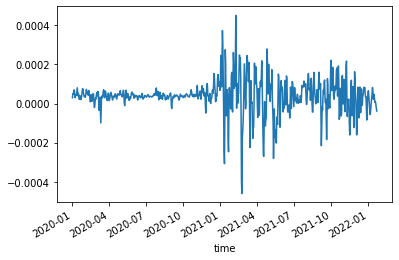

In [ ]:
new_csi_df['signal'].cumsum().plot()

In [ ]:
def get_nday_signal_col(df, day):
  '''NOTICE: dataframe requires 'signal' column'''
  name_str = 'signal_'
  day_str = str(day) + 'd'
  col_name = name_str + day_str
  df[col_name] = df['signal'].rolling(window=day).sum()
  return df

def get_percentile_col(df, col_name):
  ''' adds percentile column to dataframe'''
  data_list = df[col_name].tolist()
  percentiles_list = []
  for i in range(len(data_list)):
    val = stats.percentileofscore(data_list, data_list[i])
    percentiles_list.append(val)
  
  new_col_name = col_name + '_percentile'
  df[new_col_name] = percentiles_list
  return df

In [ ]:
signal_90 = get_nday_signal_col(new_csi_df, 90)
signal_60 = get_nday_signal_col(signal_90, 60)
signal_30 = get_nday_signal_col(signal_60, 30)
signal_15 = get_nday_signal_col(signal_30, 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
signal_90_percent = get_percentile_col(signal_15, 'signal_90d')
signal_60_percent = get_percentile_col(signal_90_percent, 'signal_60d')
signal_30_percent = get_percentile_col(signal_60_percent, 'signal_30d')
signal_15_percent = get_percentile_col(signal_30_percent, 'signal_15d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Analysis of Signals

- When the CFGI is high (blue), speculation is rapidly increasing.

- When CFGI is in the middle (yellow), speculation levels are at an equilibrium

- When CFGI is red, speculation levels are rapidly decreasing

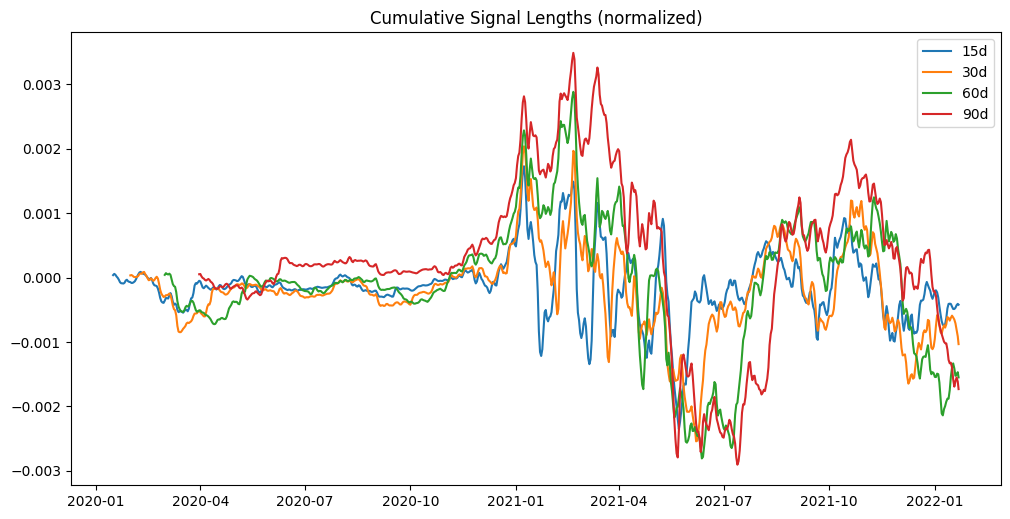

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.plot(signal_15_percent.index, signal_15_percent['signal_15d'].cumsum(), label='15d')
plt.plot(signal_15_percent.index, signal_15_percent['signal_30d'].cumsum(), label='30d')
plt.plot(signal_15_percent.index, signal_15_percent['signal_60d'].cumsum(), label='60d')
plt.plot(signal_15_percent.index, signal_15_percent['signal_90d'].cumsum(), label='90d')
plt.title('Cumulative Signal Lengths (normalized)');
plt.legend()
plt.show()

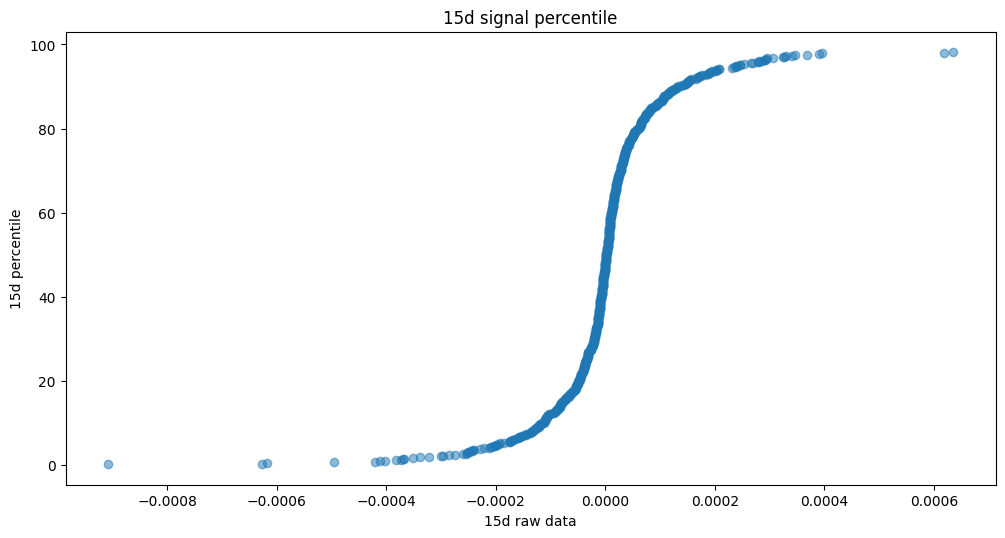

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(signal_15_percent['signal_15d'], signal_15_percent['signal_15d_percentile'], alpha=0.5)
plt.xlabel("15d raw data")
plt.ylabel("15d percentile")
plt.title("15d signal percentile")
plt.show()

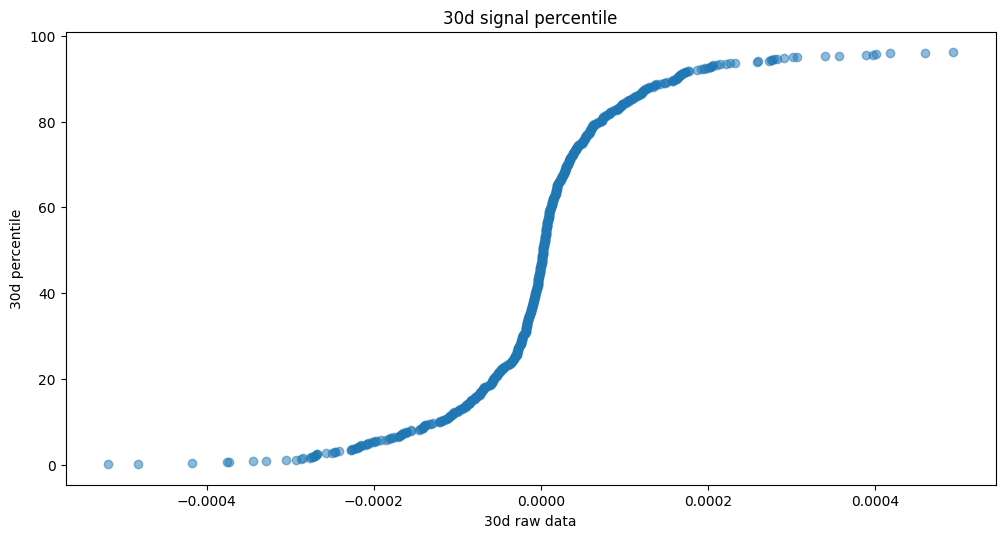

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(signal_15_percent['signal_30d'], signal_15_percent['signal_30d_percentile'], alpha=0.5)
plt.xlabel("30d raw data")
plt.ylabel("30d percentile")
plt.title("30d signal percentile")
plt.show()

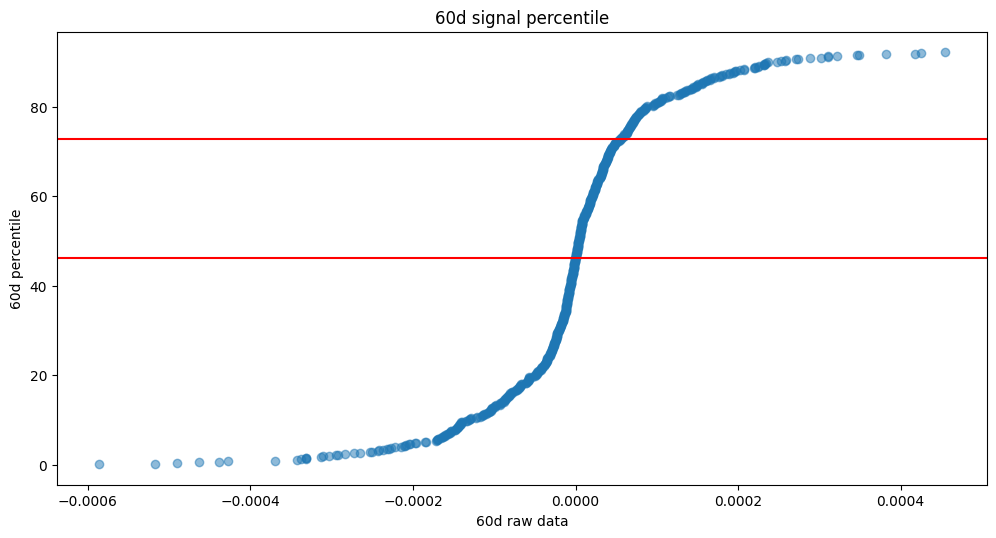

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(signal_15_percent['signal_60d'], signal_15_percent['signal_60d_percentile'], alpha=0.5)
plt.axhline(y=signal_15_percent['signal_60d_percentile'].std()+signal_15_percent['signal_60d_percentile'].mean(), color='r', linestyle='-', label='std')
plt.axhline(y=signal_15_percent['signal_60d_percentile'].mean(), color='r', linestyle='-', label='mean')
plt.xlabel("60d raw data")
plt.ylabel("60d percentile")
plt.title("60d signal percentile")
plt.show()

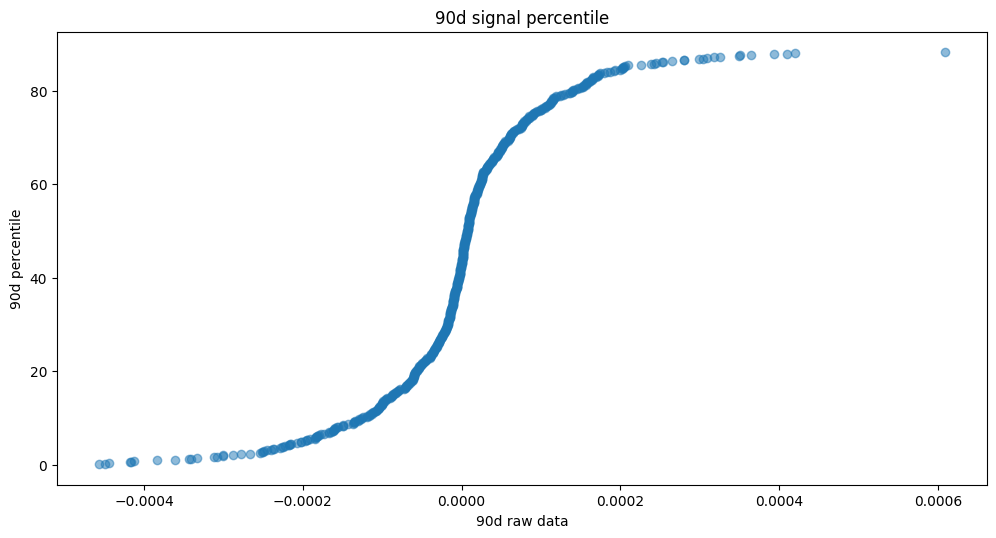

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(signal_15_percent['signal_90d'], signal_15_percent['signal_90d_percentile'], alpha=0.5)
plt.xlabel("90d raw data")
plt.ylabel("90d percentile")
plt.title("90d signal percentile")
plt.show()

In [ ]:
signal_15_percent['signal_60d_percentile'].std()

26.621828963990406

In [ ]:
signal_15_percent['signal_60d_percentile'].mean()

46.1436170212766

In [ ]:
fig = go.Figure(go.Indicator(
    value = signal_15_percent['signal_90d_percentile'][-2],
    mode = "gauge+number+delta",
    title = {'text': "90d Crypto Speculation Index (Weekly Change)"},
    delta = {'reference': signal_15_percent['signal_90d_percentile'][-9]},
    gauge = {'axis': {'range': [0, 100]},
             'steps' : [
                 {'range': [0, 50], 'color': "lightgray"},
                 {'range': [50, 100], 'color': "gray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.show()

In [ ]:
fig = go.Figure(go.Indicator(
    value = signal_15_percent['signal_60d_percentile'][-2],
    mode = "gauge+number+delta",
    title = {'text': "60d Crypto Speculation Index (Weekly Change)"},
    delta = {'reference': signal_15_percent['signal_60d_percentile'][-9]},
    gauge = {'axis': {'range': [0, 100]},
             'steps' : [
                 {'range': [0, 50], 'color': "lightgray"},
                 {'range': [50, 100], 'color': "gray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.show()

In [ ]:
fig = go.Figure(go.Indicator(
    value = signal_15_percent['signal_30d_percentile'][-2],
    mode = "gauge+number+delta",
    title = {'text': "30d Crypto Speculation Index (Weekly Change)"},
    delta = {'reference': signal_15_percent['signal_30d_percentile'][-9]},
    gauge = {'axis': {'range': [0, 100]},
             'steps' : [
                 {'range': [0, 50], 'color': "lightgray"},
                 {'range': [50, 100], 'color': "gray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.show()

In [ ]:
fig = go.Figure(go.Indicator(
    value = signal_15_percent['signal_15d_percentile'][-2],
    mode = "gauge+number+delta",
    title = {'text': "15d Crypto Speculation Index (Weekly Change)"},
    delta = {'reference': signal_15_percent['signal_15d_percentile'][-9]},
    gauge = {'axis': {'range': [0, 100]},
             'steps' : [
                 {'range': [0, 50], 'color': "lightgray"},
                 {'range': [50, 100], 'color': "gray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.show()

### stablecoin dominance vs goHm (not useful)

In [ ]:
STOP HERE

SyntaxError: ignored

In [ ]:
# import gohm data
from google.colab import drive
drive.mount('/content/gdrive')
ohm_market_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/olympus_market_fluidsonic.csv' 

Mounted at /content/gdrive


In [ ]:
ohm_market_df = pd.read_csv(ohm_market_file)
ohm_market_df = ohm_market_df[['timestamp', 'indexed_price_usd']]

ohm_market_df['timestamp'] = pd.to_datetime(ohm_market_df['timestamp']).dt.normalize()
ohm_market_df['timestamp'] = ohm_market_df['timestamp'].dt.tz_localize(None)
ohm_market_df = ohm_market_df.set_index('timestamp')

In [ ]:
# get price_ksa 
gohm_price_ksa = KSA(ohm_market_df['indexed_price_usd'])
ohm_market_df['gohm_price_ksa'] = gohm_price_ksa

In [ ]:
stable_dom_signal = signal_15_percent['stable_dom_factor']
stable_dom_signal_ksa = KSA(stable_dom_signal)
stable_dom_signal_ksa = stable_dom_signal_ksa[-302:-1]
signal_15d = signal_15_percent['signal_15d'][-302:-1]

In [ ]:
ohm_market_df['stable_dom_factor_ksa'] = stable_dom_signal_ksa
ohm_market_df['signal_15d'] = signal_15d

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.plot(ohm_market_df.index, ohm_market_df['gohm_price_ksa'], label='gohm_price_ksa')
plt.plot(ohm_market_df.index, ohm_market_df['stable_dom_factor_ksa'], label='stable_dom_factor_ksa')
plt.plot(ohm_market_df.index, ohm_market_df['signal_15d'], label='signal_15d')

plt.title('gohm price vs stable dom (normalized)');
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
plt.hist(ohm_market_df['gohm_price_ksa'], bins=100, alpha=0.5, label="gohm_price_ksa")
plt.hist(ohm_market_df['stable_dom_factor_ksa'], bins=100, alpha=0.5, label="stable_dom_factor_ksa")
plt.hist(ohm_market_df['signal_15d'], bins=100, alpha=0.5, label="signal_15d")
plt.show();

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(ohm_market_df['gohm_price_ksa'], ohm_market_df['stable_dom_factor_ksa'], alpha=0.5)
plt.xlabel("gohm_price_ksa")
plt.ylabel("stable_dom_factor_ksa")
plt.title('gohm price vs stable dom (normalized)');
plt.show()

###  stablecoin dom vs ohm price

### download data

In [ ]:
# download data to use in backtest model
signal_15_percent.to_csv('signal_15_percent.csv')
from google.colab import files
files.download("signal_15_percent.csv")